# Time Series Prediction of Flight Delays

For this effort, we will use the parquet file that has joined the FAA aircraft registration information to the BTS on-time performance data. Recognizing that there are over 52 million individual flight records, it will be necessary to aggregate the data in order to be able to create and evaluate a model in a reasonable amount of time. For the first attempt, we aggregate to the day, and will use the fraction of delayed flights in a day as the variable to predict. Using this dataset, a flight is delayed if the variable *DepDel15* or the variable *ArrDel15* is equal to 1.

We also want to identify information beyond the strict count of delayed flights that we could use as exogenous variables that could impact the trend. These might include:
* Mean distance per flight
* Number of aircraft flying on a given day
* Percentage of daily flights flown on Boeing aircraft, Airbus aircraft, etc.
* Percentage of daily flights flown on GE engines, Rolls-Royce engines, etc.


In [5]:
import pandas as pd
import duckdb

qstr = '''
select FlightDate, count(distinct Tail_Number) as Aircraft, mean(Distance) as Distance,
count(case when DepDel15==1 or ArrDel15==1 then Year end) as DelayedFlights,
count(case when DepDel15==0 and ArrDel15==0 then Year end) as OnTimeFlights,
count(case when MFR_aircraft like '%AIRBUS%' then MFR_aircraft end) as AirbusFlights,
count(case when MFR_aircraft like '%BOEING%' then MFR_aircraft end) as BoeingFlights,
count(case when MFR_aircraft like '%EMBRAER%' then MFR_aircraft end) as EmbraerFlights,
count(case when MFR like 'CFM%' then MFR end) as CFMFlights,
count(case when MFR like 'GE%' then MFR end) as GEFlights,
count(case when MFR like 'P%' then MFR end) as PWFlights,
count(case when MFR like 'ROLL%' then MFR end) as RRFlights,
count(*) as TotalFlights
from 'bts_faa_coords.parquet'
group by FlightDate
order by FlightDate
'''

df_all = duckdb.query(qstr).df()
df_all['DelayedFrac'] = df_all.DelayedFlights/df_all.TotalFlights
df_all['AirbusFrac'] = df_all.AirbusFlights/df_all.TotalFlights
df_all['BoeingFrac'] = df_all.BoeingFlights/df_all.TotalFlights
df_all['EmbraerFrac'] = df_all.EmbraerFlights/df_all.TotalFlights
df_all['CFMFrac'] = df_all.CFMFlights/df_all.TotalFlights
df_all['GEFrac'] = df_all.GEFlights/df_all.TotalFlights
df_all['PWFrac'] = df_all.PWFlights/df_all.TotalFlights
df_all['RRFrac'] = df_all.RRFlights/df_all.TotalFlights
df_all.FlightDate = pd.to_datetime(df_all.FlightDate)
df_all = df_all.set_index('FlightDate')
df_all

,Aircraft,Distance,DelayedFlights,OnTimeFlights,AirbusFlights,BoeingFlights,EmbraerFlights,CFMFlights,GEFlights,PWFlights,RRFlights,TotalFlights,DelayedFrac,AirbusFrac,BoeingFrac,EmbraerFrac,CFMFrac,GEFrac,PWFrac,RRFrac
FlightDate,,,,,,,,,,,,,,,,,,,,
2015-01-01,3753,861.363180,3700,10450,2673,5103,1351,4922,2188,1159,936,14150,0.261484,0.188905,0.360636,0.095477,0.347845,0.154629,0.081908,0.066148
2015-01-02,3823,839.398563,5556,11425,3048,6352,1588,6063,2797,1431,1119,16981,0.327189,0.179495,0.374065,0.093516,0.357046,0.164714,0.084271,0.065897
2015-01-03,3761,848.447446,7716,7944,2686,5831,1487,5452,2721,1280,1039,15660,0.492720,0.171520,0.372350,0.094955,0.348148,0.173755,0.081737,0.066347
2015-01-04,3829,837.967979,8789,7794,2978,6050,1621,5778,2783,1418,1090,16583,0.530001,0.179581,0.364831,0.097751,0.348429,0.167822,0.085509,0.065730
2015-01-05,3813,820.262227,6698,10089,2987,6210,1617,5929,2787,1384,1096,16787,0.398999,0.177935,0.369929,0.096325,0.353190,0.166021,0.082445,0.065289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,4601,834.893702,7522,13024,5918,9197,2568,10534,4870,689,418,20546,0.366105,0.288037,0.447630,0.124988,0.512703,0.237029,0.033535,0.020345
2023-06-27,4456,835.573616,6441,12828,5156,8730,2469,9771,4614,639,404,19269,0.334267,0.267580,0.453059,0.128133,0.507084,0.239452,0.033162,0.020966
2023-06-28,4509,834.919404,6160,13568,5381,8824,2464,10001,4721,654,401,19728,0.312247,0.272760,0.447283,0.124899,0.506944,0.239305,0.033151,0.020326


We recognize that the COVID-19 pandemic had a substantial impact on passenger air travel. The data from the year 2020 is not very useful, because flight delays plummeted with the number of flights actually flown. For this model, we will use data from the years 2015-2018 for training, and data from 2019 for testing.

In [14]:
df_train = df_all[:pd.to_datetime('2019-01-01')]
df_test = df_all[pd.to_datetime('2019-01-01'):pd.to_datetime('2020-01-01')]

In [19]:
# Use pmdarima to select the appropriate paramters for the ARIMA portion of the model.
# This part necessarily ignores the seasonal nature of the data.

import pmdarima as pm

ARIMA_model = pm.auto_arima(df_train['DelayedFrac'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

ARIMA_model

ARIMA(order=(1, 0, 2), scoring_args={}, suppress_warnings=True)

In [22]:
# Again, use pmdarima and add in the seasonal component

SARIMA_model = pm.auto_arima(df_train['DelayedFrac'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=7, #Annual cycle with daily data
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

SARIMA_model

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 1, 0, 7),
      suppress_warnings=True, with_intercept=False)

So, with very simplified assumptions, we now have parameters to use to train a SARIMAX model. Let's do this first without using exogenous variables. The initial assumption on seasonality would be 365 days. Training a model with this periodicity is very computationally intensive. We tried different combinations using 7, 30, and 60 days for periodicity. A value of 7 may make sense because day of the week appears in the raw data. A value of 30 may make sense because day of the month appears in the raw data. 

In the end, errors appeared to be lower with 30 day periodicity than with 7 or 60. We may not gain much by attempting 365.

In [52]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df_train['DelayedFrac'],
                                order=(1, 0, 2),
                                seasonal_order=(2,1,0,30))
results=model.fit(maxiter=100)
results.summary()

/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23949D+00    |proj g|=  4.12567D+00


 This problem is unconstrained.



At iterate    5    f= -1.27704D+00    |proj g|=  4.28218D-01

At iterate   10    f= -1.28602D+00    |proj g|=  6.15822D-02

At iterate   15    f= -1.28609D+00    |proj g|=  1.31232D-01

At iterate   20    f= -1.28650D+00    |proj g|=  1.24697D-02

At iterate   25    f= -1.28662D+00    |proj g|=  1.90369D-01

At iterate   30    f= -1.28701D+00    |proj g|=  1.43804D-02

At iterate   35    f= -1.28754D+00    |proj g|=  4.21170D-01

At iterate   40    f= -1.28970D+00    |proj g|=  2.15366D-02

At iterate   45    f= -1.28974D+00    |proj g|=  4.56686D-02

At iterate   50    f= -1.28982D+00    |proj g|=  5.10046D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         DelayedFrac   No. Observations:                 1462
Model:             SARIMAX(1, 0, 2)x(2, 1, [], 30)   Log Likelihood                1885.757
Date:                             Sun, 08 Oct 2023   AIC                          -3759.515
Time:                                     11:50:26   BIC                          -3727.914
Sample:                                 01-01-2015   HQIC                         -3747.715
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9401      0.014     65.163      0.000       0.912       0.968
ma.L1         -0.3561      0.030    -12.068      0.000      -0.414      -0.298
ma.L2         -0.3066      0.030    -10.318      0.000      -0.365      -0.248
ar.S.L30      -0.6963      0.025    -28.138      0.000      -0.745      -0.648
ar.S.L60      -0.3116      0.027    -11.538      0.000      -0.365      -0.259
sigma2         0.0042      0.000     27.743      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                11.94
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.20
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
df_res = pd.DataFrame([results.forecast(366), df_test.DelayedFrac]).T
df_res['AbsError'] = (df_res.DelayedFrac - df_res.predicted_mean).abs()
df_res.mean()

predicted_mean    0.236163
DelayedFrac       0.222356
AbsError          0.069366
dtype: float64

Let's start adding in exogenous variables

In [60]:
model=sm.tsa.statespace.SARIMAX(df_train['DelayedFrac'],
                                order=(1, 0, 2),
                                seasonal_order=(2,1,0,30),
                                exog = df_train[['BoeingFrac','AirbusFrac',
                                                 'CFMFrac','PWFrac']])
results=model.fit(maxiter=200)
results.summary()

/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25181D+00    |proj g|=  4.06261D+00

At iterate    5    f= -1.28624D+00    |proj g|=  1.39354D-01

At iterate   10    f= -1.29977D+00    |proj g|=  1.06703D+00

At iterate   15    f= -1.30113D+00    |proj g|=  1.10149D-01

At iterate   20    f= -1.30202D+00    |proj g|=  3.58450D-01

At iterate   25    f= -1.30247D+00    |proj g|=  6.66803D-02

At iterate   30    f= -1.30359D+00    |proj g|=  1.86479D-01

At iterate   35    f= -1.30528D+00    |proj g|=  3.60436D-01

At iterate   40    f= -1.31242D+00    |proj g|=  1.56246D-02

At iterate   45    f= -1.31303D+00    |proj g|=  6.10873D-02

At iterate   50    f= -1.31967D+00    |proj g|=  2.32197D-02

At iterate   55    f= -1.32115D+00    |proj g|=  8.00326D-03

At iterate   60    f= -1.32164D+00    |proj g|=  5.72067D-02

At iterate   65    f= -1.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         DelayedFrac   No. Observations:                 1462
Model:             SARIMAX(1, 0, 2)x(2, 1, [], 30)   Log Likelihood                1939.531
Date:                             Sun, 08 Oct 2023   AIC                          -3859.063
Time:                                     12:18:30   BIC                          -3806.394
Sample:                                 01-01-2015   HQIC                         -3839.396
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
BoeingFrac    -2.1049      0.376     -5.599      0.000      -2.842      -1.368
AirbusFrac    -1.8337      0.248     -7.382      0.000      -2.320      -1.347
CFMFrac        1.8684      0.388      4.813      0.000       1.107       2.629
PWFrac         2.8302      0.679      4.166      0.000       1.499       4.162
ar.L1          0.9450      0.013     72.311      0.000       0.919       0.971
ma.L1         -0.3408      0.029    -11.663      0.000      -0.398      -0.284
ma.L2         -0.2781      0.030     -9.301      0.000      -0.337      -0.220
ar.S.L30      -0.6659      0.025    -26.582      0.000      -0.715      -0.617
ar.S.L60      -0.3366      0.027    -12.560      0.000      -0.389      -0.284
sigma2         0.0039      0.000     28.182      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                23.76
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.29
Prob(H) (two-sided):                  0.63   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We attempted several combinations of exogenous variables and measured the resulting mean absolute error (MAE). Exogenous variables did serve to reduce error, but not by a very large amount. Some combinations did not allow the model to converge in a reasonable time. We began by using the mean distance, and then added fractions of aircraft manufacturers represented in the data, followed by fractions of engine manufacturers. Ultimately, distance did not turn out to be as helpful as using the fractions of Boeing aircraft, Airbus aircraft, CFM engines, and P&W engines.

The error is still substantial, but reduced from 0.0693 to 0.0648.

In [61]:
df_res = pd.DataFrame([results.forecast(366, 
                                        exog=df_test[['BoeingFrac','AirbusFrac',
                                                      'CFMFrac','PWFrac']]), 
                       df_test.DelayedFrac]).T
df_res['Error'] = df_res.predicted_mean - df_res.DelayedFrac
df_res['AbsError'] = df.Error.abs()
df_res.mean()

# With no exog, MAE was 0.069265
# Using Distance, MAE was 0.068588
# Using Distance and BoeingFrac, MAE was 0.068163
# Using Distance, BoeingFrac, AirbusFrac, MAE was 0.066966
# Using Distance, BoeingFrac, AirbusFrac, EmbraerFrac, MAE was 0.069431 - not great
# Using Distance, BoeingFrac, AirbusFrac, CFMFrac, MAE was 0.066037 - better
# Using Distance, BoeingFrac, AirbusFrac, CFMFrac, GEFrac, MAE was 0.068488 - not great did not converge by 50
# Using Distance, BoeingFrac, AirbusFrac, CFMFrac, PWFrac, MAE was 0.065026 - better, converged at 75
# Using BoeingFrac, AirbusFrac, CFMFrac, PWFrac, MAE was 0.064890 - but didn't converge
# Using BoeingFrac, AirbusFrac, CFMFrac, PWFrac, MAE was 0.064755 - converged at 150


predicted_mean    0.219006
DelayedFrac       0.222356
AbsError          0.064755
dtype: float64

In [104]:
# Try scaling up seasonal order
model=sm.tsa.statespace.SARIMAX(df_train['DelayedFrac'],
                                order=(1, 0, 2),
                                seasonal_order=(2,1,0,30),
                                exog = df_train[['BoeingFrac','AirbusFrac',
                                                 'CFMFrac','PWFrac']])
results=model.fit(maxiter=200)
results.summary()

/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Volumes/ARN_T7/Anaconda/anaconda3/envs/working/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25181D+00    |proj g|=  4.06261D+00


 This problem is unconstrained.



At iterate    5    f= -1.28624D+00    |proj g|=  1.39354D-01

At iterate   10    f= -1.29977D+00    |proj g|=  1.06703D+00

At iterate   15    f= -1.30113D+00    |proj g|=  1.10149D-01

At iterate   20    f= -1.30202D+00    |proj g|=  3.58450D-01

At iterate   25    f= -1.30247D+00    |proj g|=  6.66803D-02

At iterate   30    f= -1.30359D+00    |proj g|=  1.86479D-01

At iterate   35    f= -1.30528D+00    |proj g|=  3.60436D-01

At iterate   40    f= -1.31242D+00    |proj g|=  1.56246D-02

At iterate   45    f= -1.31303D+00    |proj g|=  6.10873D-02

At iterate   50    f= -1.31967D+00    |proj g|=  2.32197D-02

At iterate   55    f= -1.32115D+00    |proj g|=  8.00326D-03

At iterate   60    f= -1.32164D+00    |proj g|=  5.72067D-02

At iterate   65    f= -1.32399D+00    |proj g|=  1.40918D-02

At iterate   70    f= -1.32422D+00    |proj g|=  2.99118D-03

At iterate   75    f= -1.32433D+00    |proj g|=  1.53622D-02

At iterate   80    f= -1.32436D+00    |proj g|=  2.56916D-02

At iter

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         DelayedFrac   No. Observations:                 1462
Model:             SARIMAX(1, 0, 2)x(2, 1, [], 30)   Log Likelihood                1939.531
Date:                             Sun, 08 Oct 2023   AIC                          -3859.063
Time:                                     20:53:37   BIC                          -3806.394
Sample:                                 01-01-2015   HQIC                         -3839.396
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
BoeingFrac    -2.1049      0.376     -5.599      0.000      -2.842      -1.368
AirbusFrac    -1.8337      0.248     -7.382      0.000      -2.320      -1.347
CFMFrac        1.8684      0.388      4.813      0.000       1.107       2.629
PWFrac         2.8302      0.679      4.166      0.000       1.499       4.162
ar.L1          0.9450      0.013     72.311      0.000       0.919       0.971
ma.L1         -0.3408      0.029    -11.663      0.000      -0.398      -0.284
ma.L2         -0.2781      0.030     -9.301      0.000      -0.337      -0.220
ar.S.L30      -0.6659      0.025    -26.582      0.000      -0.715      -0.617
ar.S.L60      -0.3366      0.027    -12.560      0.000      -0.389      -0.284
sigma2         0.0039      0.000     28.182      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                23.76
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.29
Prob(H) (two-sided):                  0.63   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [105]:
df_res = pd.DataFrame([results.forecast(366,
                                        exog=df_test[['BoeingFrac','AirbusFrac',
                                                      'CFMFrac','PWFrac']]), 
                       df_test.DelayedFrac]).T
df_res['Error'] = df_res.predicted_mean - df_res.DelayedFrac
df_res['AbsError'] = df_res.Error.abs()
df_res.mean()

# For periodicity 60 - did not converge after 200 iterations
# predicted_mean    0.187501
# DelayedFrac       0.222356
# Error            -0.034564
# AbsError          0.068141

# For periodicity 30 - converged after 150 iterations
# predicted_mean    0.219006
# DelayedFrac       0.222356
# Error            -0.003062
# AbsError          0.064755
    
# For periodicity 7 - converged after 78 iterations
# predicted_mean    0.275687
# DelayedFrac       0.222356
# Error             0.053313
# AbsError          0.093912


predicted_mean    0.219006
DelayedFrac       0.222356
Error            -0.003062
AbsError          0.064755
dtype: float64

<Axes: >

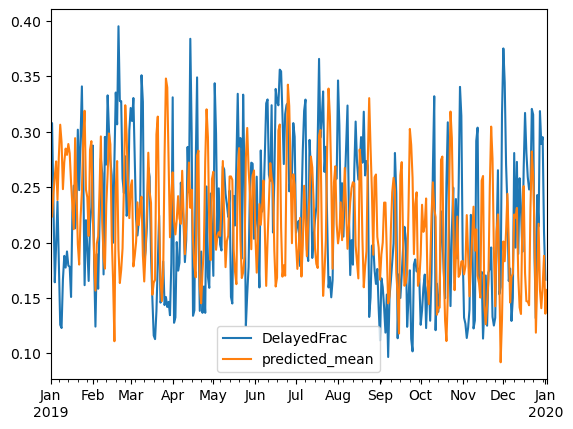

In [106]:
df_res.plot(y=['DelayedFrac','predicted_mean'])

This represents the errors in the training data.

In [94]:
df_fit = pd.DataFrame([results.fittedvalues,df_train.DelayedFrac]).T
df_fit.columns = ['FitValue', 'DelayedFrac']
df_fit['Error'] = df_fit.FitValue - df_fit.DelayedFrac
df_fit['AbsError'] = df_fit.Error.abs()

df_fit.mean()

FitValue       0.205994
DelayedFrac    0.215671
Error         -0.009677
AbsError       0.057198
dtype: float64

We tried adjusting the error by a fixed amount. While the mean error is reduced, the mean absolute error is not.

In [96]:
# This is a bad idea
df_res['adj_mean'] = df_res['predicted_mean'] + 0.003
df_res['AdjError'] = df_res.adj_mean - df_res.DelayedFrac
df_res['AbsAdjError'] = df_res.AdjError.abs()

df_res.mean()

predicted_mean    0.219006
DelayedFrac       0.222356
Error            -0.003062
AbsError          0.064755
adj_mean          0.222006
AdjError         -0.000062
AbsAdjError       0.064929
dtype: float64

We did want to ignore data from the height of the pandemic, but it might be interesting to see if the model trained on data from 2015-2018 may still have some validity on travel in 2023. In this case, the predictions seem to be consistently low. Here, we might be able to add a fixed value to the prediction and get a reasonable result.

In [117]:
df_val = df_all[pd.to_datetime('2019-01-01'):]
len(df_val)

1642

In [129]:
df_res_val = pd.DataFrame([results.forecast(steps=1642, 
                                            exog=df_val[['BoeingFrac','AirbusFrac','CFMFrac','PWFrac']])['2023-01-01':],
                           df_val['DelayedFrac']['2023-01-01':]]).T
df_res_val['Error'] = df_res_val.predicted_mean - df_res_val.DelayedFrac
df_res_val['AbsError'] = df_res_val.Error.abs()
df_res_val['adj_mean'] = df_res_val['predicted_mean'] + 0.133
df_res_val['AdjError'] = df_res_val.adj_mean - df_res_val.DelayedFrac
df_res_val['AbsAdjError'] = df_res_val.AdjError.abs()

df_res_val.mean()
              

predicted_mean    0.126567
DelayedFrac       0.259984
Error            -0.133158
AbsError          0.135817
adj_mean          0.259567
AdjError         -0.000158
AbsAdjError       0.070134
dtype: float64

<Axes: >

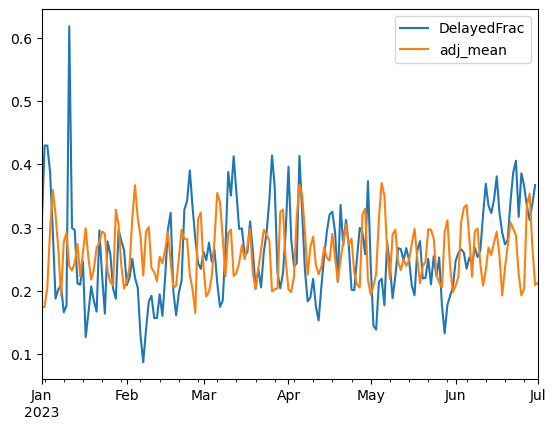

In [130]:
df_res_val.plot(y=['DelayedFrac','adj_mean'])